In [1]:
###Importing packages we need###

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import USCOUNTIES
from matplotlib.lines import Line2D
from numpy import *
import xarray as xr
from netCDF4 import Dataset, num2date
import math
import pygrib
import glob
import re
import matplotlib.patches as patches
import cdsapi
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import metpy as mp
import os
import warnings
warnings.filterwarnings("ignore")

print("Done importing modules")

Done importing modules


In [18]:
###Import the 3 CF tables and concatenate###

#Read in the 3 tables#
dfg = pd.read_csv('CSV_DFs/CF_good.csv')
dfmf = pd.read_csv('CSV_DFs/CF_mf_updated.csv')
dfu = pd.read_csv('CSV_DFs/CF_unclear_updated_new.csv')
                  
#Combine into 1 big file with all CF cases and reset index#
dfall = pd.concat([dfg, dfmf, dfu])
dfall.reset_index(drop=True, inplace=True)

#Convert 'date' column to datetime if it is not already#
dfall['date'] = pd.to_datetime(dfall['date'])

#Sort the DataFrame by 'date' and del duplicate#
dfall_sort = dfall.sort_values(by='date').reset_index(drop=True)
dfall_sort = dfall_sort.drop(260)
dfall_sort = dfall_sort.sort_values(by='date').reset_index(drop=True)

#Get all CF datasets#
df_HP_ = pd.read_csv('CSV_DFs/CF_High_Precip.csv')
df_HP = df_HP_[['date', 'max_value', 'max_time']]

df_LP_ = pd.read_csv('CSV_DFs/CF_Low_Precip.csv')
df_LP = df_LP_[['date', 'max_value', 'max_time']]

df_Full_ = pd.read_csv('CSV_DFs/CF_All_Precip.csv')
df_Full_ = df_Full_[['date', 'max_value', 'max_time']]

dfall_select = df_LP.copy()  #Can select low or high precip here for analysis
dfall_select

#dfall_select.to_csv('723CF_Final.csv', index=False)

,date,max_value,max_time
0,1950-11-02,625.744615,1950-11-01 10:00:00
1,1950-12-27,1011.129758,1950-12-26 15:00:00
2,1951-01-28,2451.093687,1951-01-27 05:00:00
3,1951-03-09,5164.179325,1951-03-08 09:00:00
4,1951-03-24,2864.818543,1951-03-23 08:00:00
...,...,...,...
140,2021-11-01,672.486578,2021-10-31 06:00:00
141,2021-11-09,393.261911,2021-11-09 02:00:00
142,2021-11-18,3125.050762,2021-11-17 10:00:00
143,2021-12-07,10677.291980,2021-12-06 01:00:00


In [19]:
###Import a test case to see the climo files for anomaly computing###

climo_path = '/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/Precip_Vars_SD/ERA5_sl_precip_SD01_01_2011.nc'
climo_test = xr.open_dataset(climo_path)
climo_test

sel_data_test = climo_test.sel(latitude=slice(41,37), longitude=slice(-105.25, -102))['tp']
sel_data_test

<xarray.DataArray 'tp' (time: 864, latitude: 17, longitude: 14)>
[205632 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -105.2 -105.0 -104.8 ... -102.5 -102.2 -102.0
  * latitude   (latitude) float32 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * time       (time) datetime64[ns] 2010-01-01 ... 2011-12-31T23:00:00
Attributes:
    units:      m
    long_name:  Total precipitation

In [20]:
###Extract the 25 hour periods centered at t=0 and compute anomalies###

#Directory containing the NetCDF files and climo files#
data_dir = '/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/Precip_Vars_SD/'

#Sort the NetCDF files#
file_list = sorted(glob.glob(data_dir + "*.nc"))

#Initialize an empty list to store DataArrays#
aligned_data_arrays = []
insufficient_data_files = []

#Extract dates from filenames and convert to datetime#
file_dates = []

for file in file_list:
    match = re.search(r'SD(\d{2}_\d{2}_\d{4})', file)
    
    if match:
        date_str = match.group(1)
        file_dates.append(pd.to_datetime(date_str, format="%m_%d_%Y"))

dfall_select['file_date'] = pd.to_datetime(dfall_select['date'])

#Sort both lists by date to ensure alignment#
dfall = dfall_select.sort_values('file_date').reset_index(drop=True)
sorted_files_with_dates = sorted(zip(file_dates, file_list))

#Loop through each row in dfall and find the corresponding precip file#
file_idx = 0

for i, row in dfall.iterrows():  #can change from all to a few cases
    while file_idx < len(sorted_files_with_dates) and sorted_files_with_dates[file_idx][0] < row['file_date']:    
        file_idx += 1

    if file_idx >= len(sorted_files_with_dates):
        break

    file_date, file = sorted_files_with_dates[file_idx]

    if file_date != row['file_date']:
        print(f"Skipping date {row['file_date']} due to no matching file")
        continue

    #Open each file and sel gridpoint and var#
    ds = xr.open_dataset(file)
    selected_data = ds.sel(latitude=slice(41,37), longitude=slice(-105.25, -102))['tp']   #Select a grid cell and variable here
    max_time = pd.to_datetime(row['max_time'])

    #Calculate start and end times for the 25-hour period#
    hours_sel = 12   #the window size
    hrs2 = hours_sel * 2 + 1
    #hrs2 = hours_sel + 1
    #start_time = max_time
    start_time = max_time - timedelta(hours=hours_sel)   #can adjust, window start 
    end_time = max_time + timedelta(hours=hours_sel)     #can adjust, window end
    #end_time = max_time    
    time_array = pd.date_range(start=start_time, end=end_time, freq='H')
    #print(time_array)

    #Select the data for the 25-hour period#
    selected_data_t = selected_data.sel(time=slice(start_time, end_time))

    #Only include the data if it has the full 25-hour period#
    if selected_data_t.shape[0] == hrs2:

        #Combine anomalies into a single DataArray#
        precip_tots_da = xr.concat(selected_data_t, dim='time')
        aligned_data_arrays.append(precip_tots_da)
    
    else: 
        print(f"Skipping file {file} due to insufficient data")
        insufficient_data_files.append((file, selected_data_t.time.values))

#Handle files with insufficient data and fill with Nans#
for file, times in insufficient_data_files:
    
    #Create an array of NaNs with the required shape#
    full_times = pd.date_range(start=start_time, end=end_time, freq='H')
    nan_data = xr.DataArray(np.full((hrs2,), np.nan), dims=['time'], coords={'time': full_times})
    
    #Append to the total array#
    aligned_data_arrays.append(nan_data)

In [21]:
###Now accumulate the precip over the full domain###

#Initialize an empty list to store accumulated precipitation data#
accumulated_precip_arrays = []

#Accumulate precipitation across the time dimension#
for data_array in aligned_data_arrays:
    
    accumulated_precip = data_array.sum(dim='time')  #Sum along the time dimension
    accumulated_precip_arrays.append(accumulated_precip)
    
#Initialize an empty list to store the total precipitation for each cold front#
total_precip_values = []

#Sum precip across all grid cells#
for idx, accumulated_precip in enumerate(accumulated_precip_arrays):
    
    total_precip = accumulated_precip.sum(dim=['latitude', 'longitude']) * 1000  #convert to mm from m
    time = dfall_select.iloc[idx]['date']  #Use the 'date' column from dfall_select as the time
    total_precip_values.append((time, total_precip.item()))  #Store time and total precip as a tuple

##Add the total precipitation as a new column in dfall##

#Convert the list of tuples into a DataFrame#
total_precip_df = pd.DataFrame(total_precip_values, columns=['date', 'total_precip'])
#total_precip_df

#Merge this DataFrame with dfall_select based on the 'date' column#
dfall_select = dfall_select.merge(total_precip_df, on='date')

#Drop a couple useless columns#
#dfall_select = dfall_select.drop(columns=['total_precip_x', 'total_precip_y'])
dfall_select

,date,max_value,max_time,file_date,total_precip
0,1950-11-02,625.744615,1950-11-01 10:00:00,1950-11-02,0.039172
1,1950-12-27,1011.129758,1950-12-26 15:00:00,1950-12-27,61.792616
2,1951-01-28,2451.093687,1951-01-27 05:00:00,1951-01-28,4.875601
3,1951-03-09,5164.179325,1951-03-08 09:00:00,1951-03-09,9.902985
4,1951-03-24,2864.818543,1951-03-23 08:00:00,1951-03-24,13.509710
...,...,...,...,...,...
140,2021-11-01,672.486578,2021-10-31 06:00:00,2021-11-01,15.182394
141,2021-11-09,393.261911,2021-11-09 02:00:00,2021-11-09,9.922114
142,2021-11-18,3125.050762,2021-11-17 10:00:00,2021-11-18,62.295407
143,2021-12-07,10677.291980,2021-12-06 01:00:00,2021-12-07,7.024482


In [22]:
###Elevation data###

#ERA5 terrain stuff with geopotential#
input_elv = 'Other_Data/terrain_0.1.nc'
df_elevation = xr.open_dataset(input_elv)
#df_elevation['z'].plot()

#Define bounds for all of Colorado#
lon_min = 251  
lon_max = 258   
lat_min = 37
lat_max = 41

#Slice out the array and convert to height [m]# 
df_ele_CO = df_elevation.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))
heights = (df_ele_CO['z'][0,:,:].values) / 9.81
heights

array([[2427.43552539, 2442.79487629, 2322.68475226, ..., 1086.97377454,
        1082.87794764, 1072.5359847 ],
       [2150.55762651, 2193.25662201, 2148.40731738, ..., 1122.50507296,
        1107.7600961 , 1090.04564472],
       [2022.15345299, 1984.67663679, 1965.73343735, ..., 1141.4482724 ,
        1117.79487202, 1093.32230625],
       ...,
       [1606.22223063, 1753.26241657, 1869.68629639, ..., 1170.63103911,
        1132.23266186, 1099.67083796],
       [1478.02284845, 1580.62331246, 1687.62679039, ..., 1147.18243007,
        1113.28946242, 1089.84085338],
       [1445.97300291, 1473.10785616, 1539.97223041, ..., 1142.26743778,
        1120.8667422 , 1104.89301726]])

In [23]:
###Import the binary mask###

binmask = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/binary_mask_T52.nc')
binmask

<xarray.Dataset>
Dimensions:          (latitude: 17, longitude: 14)
Dimensions without coordinates: latitude, longitude
Data variables:
    binary_mask_tcf  (latitude, longitude) bool ...

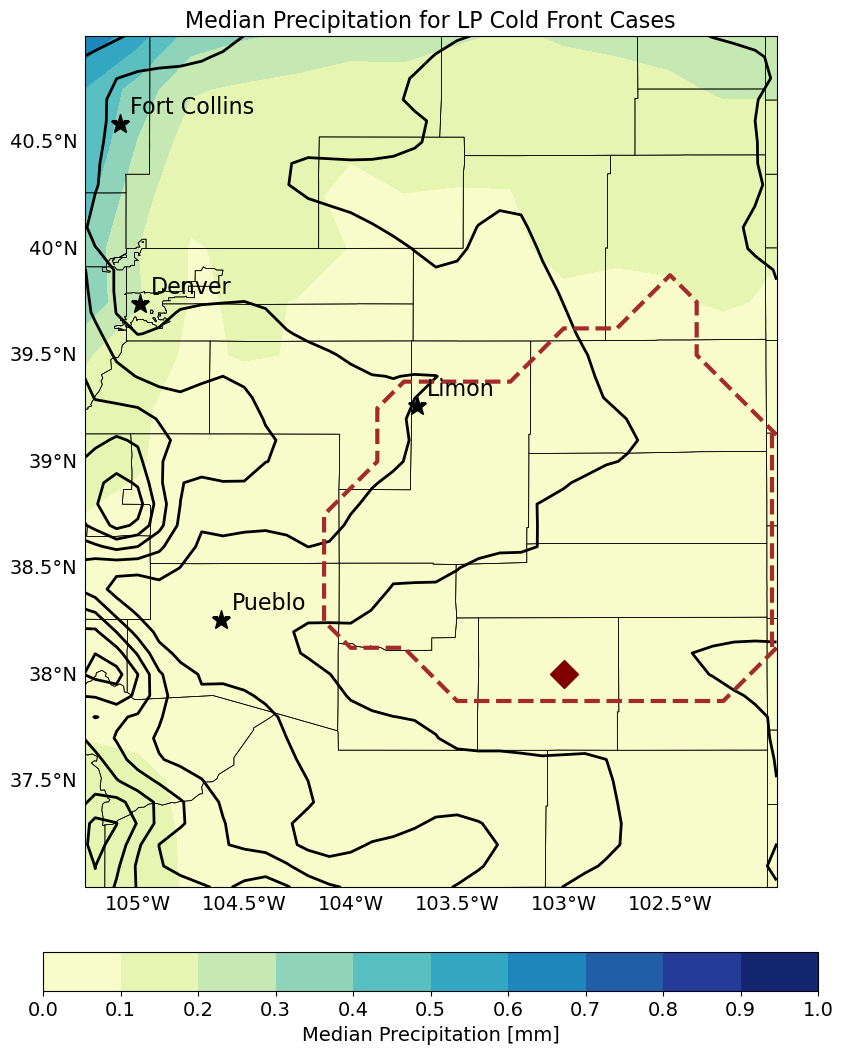

In [27]:
###Make some mean maps of Precip###

import matplotlib.colors as mcolors

#Make into an xr#
precip_data = xr.concat(accumulated_precip_arrays, dim='case')
precip_data

#Get the mean and the total accumulated
mean_p_data = precip_data.mean(dim='case')
sum_p_data = precip_data.sum(dim='case')

#Get the lons and lats#
lons = mean_p_data['longitude'].values
lats = mean_p_data['latitude'].values

#Define the extent to tightly fit the data area#
lon_min, lon_max = np.min(lons), np.max(lons)
lat_min, lat_max = np.min(lats), np.max(lats)

#Coordinates of the cities#
cities = {
   "Fort Collins": (40.5853, -105.0844),
    "Denver": (39.7392, -104.9903),
    "Limon": (39.26, -103.69),
    "Pueblo": (38.2544, -104.6091)
}

#Get precip levs#
#levs_precip = np.arange(0,18, 0.4)
levs_precip = np.arange(0,1.1, 0.1)
#levs_precip = np.arange(0,8.4, 0.4)

#Plotting the overall mean map#
fig, ax = plt.subplots(1, figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})
im1 = plt.contourf(mean_p_data.longitude, mean_p_data.latitude, mean_p_data*1000, cmap='YlGnBu', levels=levs_precip, interpolation='none', transform=ccrs.PlateCarree())

#Plot the elevation spatial data#
clevels = np.arange(800, 4000, 300)
im2 = plt.contour(df_ele_CO['longitude'], df_ele_CO['latitude'], heights, levels=clevels, colors='black', origin='lower', linewidths=2) 

#Plot the T52 regions and single gridpoint for TS#
binmask_data = binmask['binary_mask_tcf'].values
im3 = ax.contour(lons, lats, binmask_data, levels=[0.5], colors='brown', linestyles='dashed', linewidths=3, transform=ccrs.PlateCarree())
ax.plot(-103, 38, marker='D', markersize=14, color='maroon', transform=ccrs.PlateCarree()) 

#Add vertical line at the eastern edge of T52 region#
T52_east_edge = -102.02  # adjust if needed
ax.plot([T52_east_edge, T52_east_edge], [38.13, 39.14],
        color='brown', linewidth=3, linestyle='dashed',
        transform=ccrs.PlateCarree(), zorder=5)

#Configure the cbar#
cbar = plt.colorbar(im1, orientation='horizontal', pad=0.06)
cbar.set_label('Median Precipitation [mm]', fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks(np.arange(0, 1.1, 0.1))  #change

#Add the cities with stars#
for city, (lat, lon) in cities.items():
    plt.plot(lon, lat, marker='*', color='black', markersize=14)
    plt.text(lon + 0.05, lat + 0.05, city, fontsize=16, color='black')
    
#Add county borders#
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.5)

#Set the extent to only show the area with data#
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

#Add gridlines and labels for latitude and longitude#
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='none')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}

#Add titles and labels#
plt.title('Median Precipitation for LP Cold Front Cases', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

#Save the fig#
#plt.savefig("CF_Precip_LP_Median.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

#Show the plot#
plt.show()

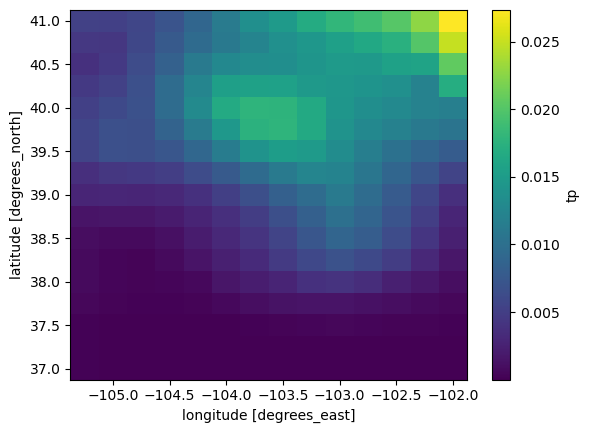

In [10]:
accumulated_precip_arrays[144].plot()

In [11]:
###Select the top and bottom 20% quartiles for low and high precip subsets###

#Calculate the 20th and 80th percentiles for total_precip#
low_thresh = dfall_select['total_precip'].quantile(0.20)
high_thresh = dfall_select['total_precip'].quantile(0.80)

#Select the cold fronts in the top 20% as high_precip_CF#
high_precip_CF = dfall_select[dfall_select['total_precip'] >= high_thresh]

#Select the cold fronts in the bottom 20% as low_precip_CF#
low_precip_CF = dfall_select[dfall_select['total_precip'] <= low_thresh]

#Find the row with the maximum total precipitation#
max_precip_row = high_precip_CF.loc[high_precip_CF['total_precip'].idxmax()]

#All Precip#
all_precip_CF = dfall_select.copy()

#Display the result#
high_precip_CF

,date,max_value,max_time,file_date,total_precip
4,1951-10-06,1369.330734,1951-10-05 13:00:00,1951-10-06,3340.264559
7,1952-03-22,1757.497715,1952-03-21 04:00:00,1952-03-22,3182.072163
10,1952-05-17,5304.889198,1952-05-16 11:00:00,1952-05-17,4370.862961
17,1955-04-13,6110.460621,1955-04-12 07:00:00,1955-04-13,3462.772369
24,1958-05-09,1504.046125,1958-05-08 17:00:00,1958-05-09,3273.040771
27,1959-03-21,560.836622,1959-03-20 03:00:00,1959-03-21,3477.436543
29,1960-01-15,2172.268248,1960-01-14 10:00:00,1960-01-15,4251.162052
34,1961-05-14,4496.907993,1961-05-14 01:00:00,1961-05-14,5619.677067
45,1966-10-15,3756.506986,1966-10-14 11:00:00,1966-10-15,3454.855680
47,1967-05-27,13558.302420,1967-05-26 23:00:00,1967-05-27,5818.317413


In [12]:
low_thresh, high_thresh

(1317.152452468872, 3177.965831756592)

In [ ]:
###Save the df above###
# high_precip_CF.to_csv('CF_High_RShr.csv', index=False)
# low_precip_CF.to_csv('CF_Low_RShr.csv', index=False)
# dfall_select.to_csv('CF_All_RShr.csv', index=False)

In [ ]:
###Can read in those 3 precipitation subsets###
# high_precip_CF = pd.read_csv('CSV_DFs/CF_High_Precip.csv')
# low_precip_CF = pd.read_csv('CSV_DFs/CF_Low_Precip.csv')
# all_precip_CF = pd.read_csv('CSV_DFs/CF_All_Precip.csv')

# low_precip_CF

In [ ]:
###Plotting the histogram###

# total number of cold front cases
n_cases = len(dfall_select['total_precip'])

# build weights so that the sum of the bar heights is 100 (%)
weights = np.ones_like(dfall_select['total_precip']) / n_cases * 100

# Plot histogram in % instead of raw counts
plt.figure(figsize=(12, 8))
plt.hist(
    dfall_select['total_precip'],
    bins=40,
    weights=weights,             # <-- use weights to get percentages
    color='dodgerblue',
    alpha=1,
    edgecolor='black'
)

#Add vertical lines at low and high threshold#
#plt.axvline(0, color='black', linestyle='--', linewidth=2, label='Low Precipitation Set  N=145')
plt.axvline(low_thresh, color='black', linestyle='--', linewidth=2, label='Low Precipitation Set  N=145')
plt.axvline(high_thresh, color='maroon', linestyle='--', linewidth=2, label='High Precipitation Set  N=145')
#plt.axvline(8750, color='maroon', linestyle='--', linewidth=2)

# # Add arrows pointing to the left (low precip) and right (high precip)
# plt.annotate('', xy=(low_thresh - 450, 50), xytext=(low_thresh - 60 , 50),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate('', xy=(high_thresh + 450, 50), xytext=(high_thresh + 60, 50),
#              arrowprops=dict(facecolor='maroon', shrink=0.05))

#Configure the plot#
plt.yscale('log')
yticks = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50]
plt.yticks(yticks, [f"{y:.1f}%" for y in yticks], fontsize=14)
plt.title('Total Domain Summed Precipitation for All Cold Front Cases', fontsize=18)
plt.xlabel('Total Precipitation Accumulated Across Eastern CO [mm]', fontsize=16)
plt.xticks(np.arange(0,9000,500), fontsize=14)
plt.ylabel('Frequency [%]', fontsize=16)
plt.xticks(rotation=45)
plt.legend(fontsize=14)
#plt.grid(True)

plt.savefig("Precipitation_Groups__REV.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [ ]:
###Plotting high and low precip groups by time of day###

#Convert to dt and extract hour
max_time_Allcf = pd.to_datetime(all_precip_CF['max_time'], format='%Y-%m-%d %H:%M:%S')
all_precip_CF['hour'] = max_time_Allcf.dt.hour

#Group by hour and count occurrences#
hourly_frequency = all_precip_CF.groupby('hour').size()

#Get the %#
total_e = hourly_frequency.sum()
percent_frequency = (hourly_frequency / total_e) * 100

##Now with LP##

#Convert to dt and extract hour
max_time_LPcf = pd.to_datetime(low_precip_CF['max_time'], format='%Y-%m-%d %H:%M:%S')
low_precip_CF['hour'] = max_time_LPcf.dt.hour

#Group by hour and count occurrences#
hourly_frequencyLP = low_precip_CF.groupby('hour').size()

#Create a complete index for all hours (0 to 23)#
all_hours_LP = pd.Index(range(24), name='hour')

#Reindex the hourly_frequency to include all hours, filling missing values with 0#
hourly_frequencyLP = hourly_frequencyLP.reindex(all_hours_LP, fill_value=0)

#Get the %#
total_e_LP = hourly_frequencyLP.sum()
percent_frequency_LP = (hourly_frequencyLP / total_e_LP) * 100

##Now with HP##

#Convert to dt and extract hour
max_time_HPcf = pd.to_datetime(high_precip_CF['max_time'], format='%Y-%m-%d %H:%M:%S')
high_precip_CF['hour'] = max_time_HPcf.dt.hour

#Group by hour and count occurrences#
hourly_frequencyHP = high_precip_CF.groupby('hour').size()

#Get the %#
total_e_HP = hourly_frequencyHP.sum()
percent_frequency_HP = (hourly_frequencyHP / total_e_HP) * 100

#Plotting#
plt.figure(figsize=(14, 6))

#Set the positions of the bars on the x-axis#
bar_width = 0.3
spacing = 0.5

# r1 = np.arange(len(hourly_frequency))
# r2 = [x + bar_width for x in r1]
# r3 = [x + bar_width for x in r2]

r1 = np.arange(24) * (bar_width * 3 + spacing)
r2 = r1 + bar_width
r3 = r2 + bar_width

plt.bar(r1, percent_frequency, color='skyblue', width=bar_width, edgecolor='black', label='All Fronts  N=723')
plt.bar(r2, percent_frequency_LP, color='brown', width=bar_width, edgecolor='black', label='LP Fronts  N=145')
plt.bar(r3, percent_frequency_HP, color='lightgreen', width=bar_width, edgecolor='black', label='HP Fronts  N=145')

labelsize = 18
ticksize = 16

plt.title('Cold Front Hourly Frequency', fontsize=20)
plt.xlabel('UTC Time', fontsize=labelsize)
xtick_positions = r1 + bar_width  # Center of each group
plt.xticks(xtick_positions, np.arange(24), fontsize=ticksize)
# plt.xticks(fontsize=ticksize, rotation=0)
# plt.xticks([r1 + bar_width for r1 in range(len(hourly_frequency))], np.arange(0,24,1)) 
#plt.xticks([r1 + bar_width for r1 in range(len(hourly_frequency))], [18,19,20,21,22,23,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]) 
plt.ylabel('Frequency [%]', fontsize=labelsize)
plt.yticks(fontsize=ticksize)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
#plt.tick_params(axis='x', pad=5)

#plt.savefig("TOD_UTC.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()